# UnB/PPCA - Fundamentos de Pesquisa Operacional (2020-002)
## Trabalho 3 - Solvers para PL
### Grupo:
Eric Hans Messias da Silva <br> João Laterza <br> Marcos Paulo Pereira da Silva
___
___

### Bibliotecas utilizadas

In [1]:
import pulp as pl, pandas as pd, os
from pulp import LpMaximize, LpMinimize, LpProblem, LpStatus, lpSum, LpVariable, CPLEX_CMD, GUROBI_CMD, GLPK_CMD

### Solvers

In [2]:
print('Solvers:', ', '.join(pl.listSolvers(onlyAvailable=True)))

Solvers: GLPK_CMD, CPLEX_CMD, GUROBI_CMD


### Funções utilizadas

In [3]:
def method_select(solver, method):
    """
    A função recebe um solver e um inteiro representando o método a ser usado e retorna uma tupla contendo o código a ser inserido no solver e o nome do método.
    solver: 'GLPK', 'CPLEX' ou 'GUROBI'
    method:
        GLPK:
        0 = Automático
        1 = Primal Simplex
        2 = Dual Simplex           
        3 = Primal-Dual Interior-Point
        CPLEX:
        0 = Automático
        1 = Primal Simplex
        2 = Dual Simplex 
        3 = Network 
        4 = Barrier
        5 = Sifting
        6 = Concurrent Dual, Barrier, Primal Optimizer    
        GUROBI:
        0 = Automático
        1 = Primal Simplex
        2 = Dual Simplex
        3 = Barrier
        4 = Concurrent
        5 = Deterministic Concurrent
        6 = Deterministic Concurrent Simplex   
    """
    glpk_n = {1: 'Primal Simplex', 2: 'Dual Simplex', 3: 'Primal-Dual Interior-Point'}; glpk_v = {1: '--primal', 2: '--dual', 3: '--interior'}
    cplex_n = {1: 'Primal Simplex', 2: 'Dual Simplex', 3: 'Network', 4: 'Barrier', 5: 'Sifting', 6: 'Concurrent'}
    gurobi_n = {1: 'Primal Simplex', 2: 'Dual Simplex', 3: 'Barrier', 4: 'Concurrent', 5: 'Deterministic Concurrent', 6: 'Deterministic Concurrent Simplex'}
    
    if method == 0:
        return ([], 'Automatico')
    elif solver == 'GLPK':
        return ([glpk_v[method]], glpk_n[method])
    elif solver == 'CPLEX':
        return (['set LPMethod '+str(method)], cplex_n[method])
    elif solver == 'GUROBI':
        return ([('Method', method-1)], gurobi_n[method])
    else:
        return None

def solver_apply(model, solver = 'GLPK', kind = 'Max', method = 0, keepFiles = False, imprimir = True):
    """
    A função recebe o modelo a ser resolvido,
    o nome do solver (solver) a ser utilizado,
    e o tipo do problema de otimização envolvido (kind)
    e retorna a solução para o problema, imprimindo os resultados.
    
    model: modelo a ser resolvido (formato 'LpProblem')
    solver: 'GLPK', 'CPLEX' ou 'GUROBI'
    kind: 'Max' para maximização ou 'Min' para minimização.
    method: Método a ser utilizado pelo solver.
        GLPK:
        0 = Automático
        1 = Primal Simplex
        2 = Dual Simplex           
        3 = Primal-Dual Interior-Point
        CPLEX:
        0 = Automático
        1 = Primal Simplex
        2 = Dual Simplex 
        3 = Network 
        4 = Barrier
        5 = Sifting
        6 = Concurrent Dual, Barrier, Primal Optimizer    
        GUROBI:
        0 = Automático
        1 = Primal Simplex
        2 = Dual Simplex
        3 = Barrier
        4 = Concurrent
        5 = Deterministic Concurrent
        6 = Deterministic Concurrent Simplex    
    keepFiles: 'True' para salvar os arquivos em diretório local; 'False' para armazenar em pasta temporária.
    imprimir: 'True' para imprimir os resultados e 'False' para omiti-los.
    """           
    model_res = model.copy()
    
    m = method_select(solver, method)
        
    if solver == 'GLPK':
        solver_f = GLPK_CMD(options = m[0], keepFiles = keepFiles)
    elif solver == 'CPLEX':
        solver_f = CPLEX_CMD(options = m[0], keepFiles = keepFiles)
    elif solver == 'GUROBI':
        solver_f = GUROBI_CMD(options = m[0], keepFiles = keepFiles)
    else:
        print('Modelo inválido.')
        return None
    
    model_res.solve(solver_f)
    if imprimir:
        print(f'{solver} ({LpStatus[model_res.status]}):')
        print('Método:', m[1])
        print(f'Tempo: {model_res.solutionTime}s')
        print(f'Z: {model_res.objective.value()}')
        for var in model_res.variables(): print(f'{var.name}: {var.value()}')
        for name, constraint in model_res.constraints.items(): print(f'{name}: {constraint.value()}')
        print(model_res.solver)
        print('-'*60)
        print(f'\033[1m{kind} Z = {model_res.objective.value()}, x = ({", ".join([str(var.value()) for var in model_res.variables()])})\033[0m')
    return model_res

def calendar_apply(model):
    """
    A função recebe um modelo (formato 'LpProblem') e retorna um data frame contendo a carga horária escalada para cada operador em cada dia da semana.
    """
    model = model.copy()
    lst = [c.value() for c in model.objective.keys()]
    df = pd.DataFrame([lst[:5], lst[5:10], lst[10:15], lst[15:20], lst[20:25], lst[25:30]])
    df.index = ['K.C.', 'D.H.', 'H.B.', 'S.C.', 'K.S.', 'N.K.']; df.columns = ['Seg.', 'Ter.', 'Qua.', 'Qui.', 'Sex.']
    df['TOTAL'] = df.sum(axis = 1); df.loc['TOTAL'] = df.sum(axis = 0)
    return df

___
___

### Problema 1

A Empresa de Manufatura Ômega descontinuou a produção de determinada linha de produtos não lucrativa. Esse fato acabou criando considerável excesso de capacidade produtiva. A direção está levando em conta a possibilidade de dedicar esse excesso de capacidade produtiva para um ou mais produtos. Vamos chamá-los produtos 1, 2 e 3. A capacidade disponível nas máquinas que poderiam limitar a produção encontra-se resumida na tabela a seguir: 

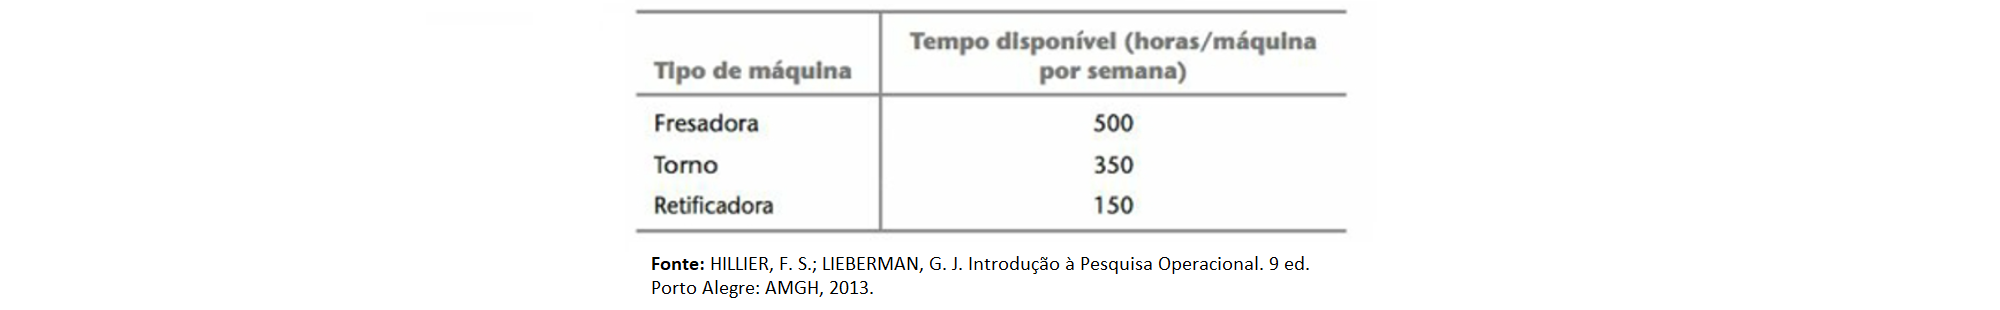

O número de horas/máquina exigidas para cada unidade do respectivo produto é: 

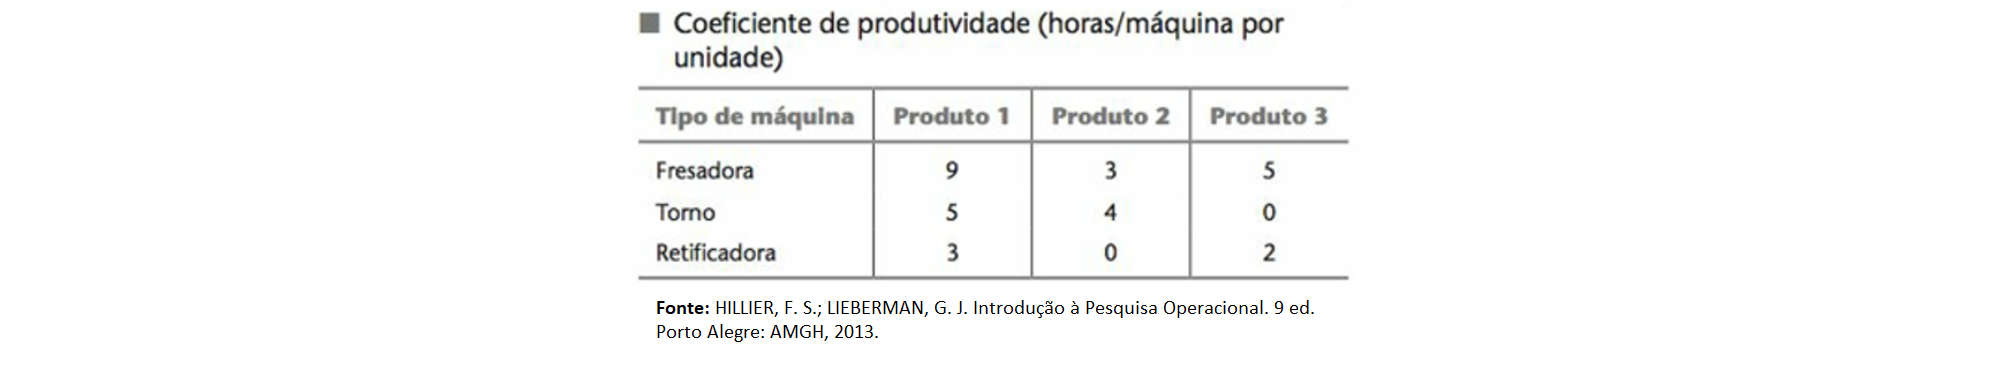

O departamento de vendas sinaliza que o potencial de vendas para os produtos 1 e 2 excede a taxa de produção máxima e que o potencial de vendas para o produto 3 é de 20 unidades por semana. O lucro unitário seria, respectivamente, de US$ 50, 20 e 25 para os produtos 1, 2 e 3. O objetivo é determinar quanto de cada produto a Ômega deveria produzir para maximizar os lucros.
___

<b>Resolução:</b>

<font color='blue'> Função objetivo </font> (<b>Z</b>): <b>50x₁ + 20x₂ + 25x₃</b> <br>
<font color='red'> Conjunto viável: </font><br>
Restrição de produtividade da fresadora (<b>r₁</b>): <b>9x₁ + 3x₂ + 5x₃ ≤ 500</b> <br>
Restrição de produtividade do torno (<b>r₂</b>): <b>5x₁ + 4x₂ + 0x₃ ≤ 350</b> <br>
Restrição de produtividade da retificadora (<b>r₃</b>): <b>3x₁ + 0x₂ + 2x₃ ≤ 150</b> <br>
Restrição de potencial de vendas (<b>r₄</b>): <b>x₃ ≤ 20</b> <br>
* variáveis x₁, x₂ e x₃: quantidade (em unidades) de produtos a ser produzida
* problema de otimização linear visando a maximização dos lucros

In [4]:
# Criando o modelo
model = LpProblem(name = 'PROBLEMA_1', sense = LpMaximize)

# Iniciando as variáveis de decisão
cat = 'Integer'
x1 = LpVariable(name = 'x1', lowBound=0, cat = cat)
x2 = LpVariable(name = 'x2', lowBound=0, cat = cat)
x3 = LpVariable(name = 'x3', lowBound=0, cat = cat)

# Adicionando as restrições ao modelo
model += (9*x1 + 3*x2 + 5*x3 <= 500, 'r1')
model += (5*x1 + 4*x2 + 0*x3 <= 350, 'r2')
model += (3*x1 + 0*x2 + 2*x3 <= 150, 'r3')
model += (x3 <= 20, 'r4')

# Adicionando a função objetivo ao modelo
model += 50*x1 + 20*x2 + 25*x3

In [5]:
# Verificando o modelo
print(str(model).replace('\n\n','\n'))

PROBLEMA_1:
MAXIMIZE
50*x1 + 20*x2 + 25*x3 + 0
SUBJECT TO
r1: 9 x1 + 3 x2 + 5 x3 <= 500
r2: 5 x1 + 4 x2 <= 350
r3: 3 x1 + 2 x3 <= 150
r4: x3 <= 20
VARIABLES
0 <= x1 Integer
0 <= x2 Integer
0 <= x3 Integer



<b>GLPK</b>

In [6]:
_ = solver_apply(model, solver = 'GLPK', kind = 'Max', method = 0, keepFiles = False, imprimir = True)

GLPK (Optimal):
Método: Automatico
Tempo: 0.0s
Z: 2900
x1: 26
x2: 55
x3: 20
r1: -1
r2: 0
r3: -32
r4: 0
------------------------------------------------------------
Max Z = 2900, x = (26, 55, 20)


<b>CPLEX</b>

In [8]:
_ = solver_apply(model, solver = 'CPLEX', kind = 'Max', method = 0, keepFiles = False, imprimir = True)

CPLEX (Optimal):
Método: Automatico
Tempo: 0.0s
Z: 2900.0
x1: 26.0
x2: 55.0
x3: 20.0
r1: -1.0
r2: 0.0
r3: -32.0
r4: 0.0
------------------------------------------------------------
Max Z = 2900.0, x = (26.0, 55.0, 20.0)


<b>GUROBI</b>

In [9]:
_ = solver_apply(model, solver = 'GUROBI', kind = 'Max', method = 0, keepFiles = False, imprimir = True)

GUROBI (Optimal):
Método: Automatico
Tempo: 0.0s
Z: 2900.0
x1: 26.0
x2: 55.0
x3: 20.0
r1: -1.0
r2: 0.0
r3: -32.0
r4: 0.0
------------------------------------------------------------
Max Z = 2900.0, x = (26.0, 55.0, 20.0)


<br>
<b> Como resultado, a Empresa de Manufatura Ômega deveria produzir semanalmente 26, 55 e 20 unidades dos produtos 1, 2 e 3, respectivamente, para maximizar seus lucros, obtendo assim US$ 2.900,00 por semana. </b>

___
___

### Problema 2

A empresa Medequip produz equipamentos de diagnóstico médico de precisão em duas fábricas. As clínicas médicas fizeram pedidos para a produção deste mês. A tabela abaixo mostra qual seria o custo para despachar cada unidade de equipamento de cada fábrica para cada um desses clientes. Também é indicado o número de unidades que será produzido em cada fábrica, bem como o número de unidades destinado a cada cliente. 

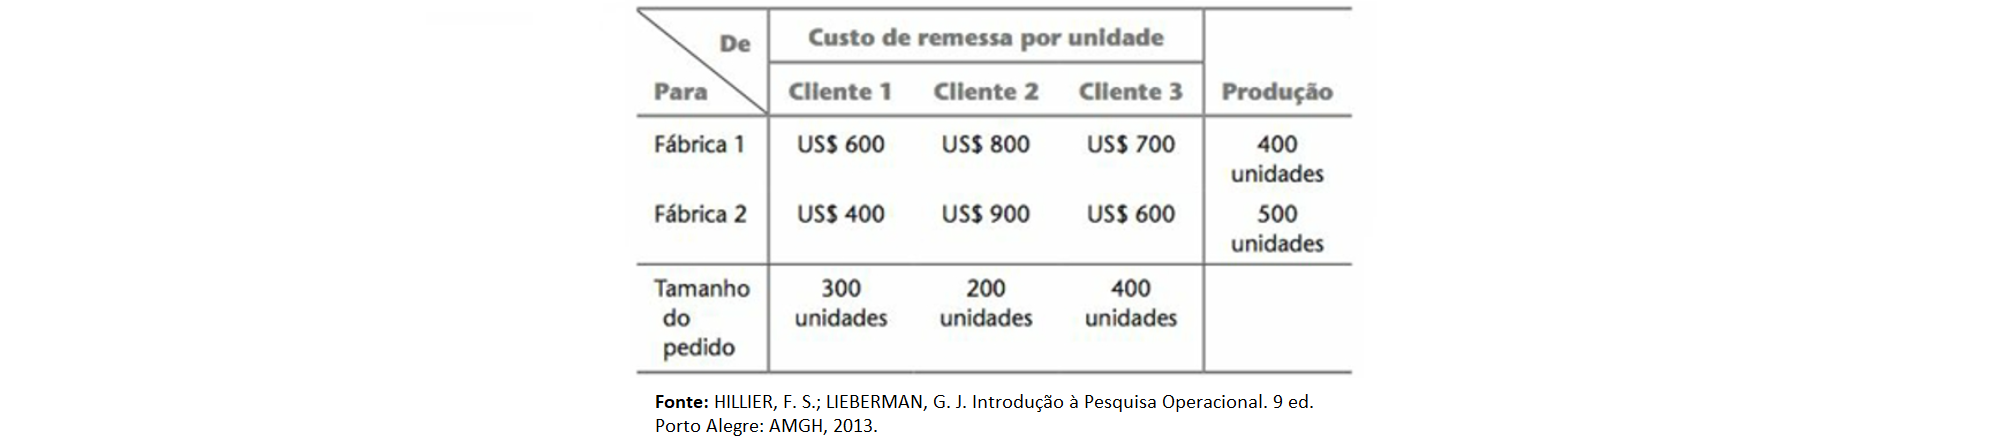

Agora, é necessário tomar uma decisão em relação ao plano de remessa da mercadoria, ou seja, quantas unidades de cada fabrica para cada cliente.
___

<b>Resolução:</b>

<font color='blue'> Função objetivo </font> (<b>Z</b>): <b>600x₁ + 800x₂ + 700x₃ + 400x₄ + 900x₅ + 600x₆</b> <br>
<font color='red'> Conjunto viável: </font><br>
Restrição de produtividade da Fábrica 1 (<b>r₁</b>): <b>x₁ + x₂ + x₃ = 400 </b> <br>
Restrição de produtividade do Fábrica 2 (<b>r₂</b>): <b>x₄ + x₅ + x₆ = 500 </b> <br>
Restrição pedidos do Cliente 1 (<b>r₃</b>): <b>x₁ + x₄ = 300</b> <br>
Restrição pedidos do Cliente 2 (<b>r₄</b>): <b>x₂ + x₅ = 200</b> <br>
Restrição pedidos do Cliente 3 (<b>r₅</b>): <b>x₃ + x₆ = 400</b> <br>
* como a empresa deve atender a todos os pedidos dos clientes e a quantidade de produção é igual a quantidade demandada, as restrições adotadas são de igualdade 
* variável x₁: quantidade de equipamentos (em unidades) a ser enviada da Fábrica 1 para o Cliente 1
* variável x₂: quantidade de equipamentos (em unidades) a ser enviada da Fábrica 1 para o Cliente 2
* variável x₃: quantidade de equipamentos (em unidades) a ser enviada da Fábrica 1 para o Cliente 3
* variável x₄: quantidade de equipamentos (em unidades) a ser enviada da Fábrica 2 para o Cliente 1
* variável x₅: quantidade de equipamentos (em unidades) a ser enviada da Fábrica 2 para o Cliente 2
* variável x₆: quantidade de equipamentos (em unidades) a ser enviada da Fábrica 2 para o Cliente 3
* problema de otimização linear visando a minimização dos custos de remessa

In [10]:
# Criando o modelo
model = LpProblem(name = 'PROBLEMA_2', sense = LpMinimize)

# Iniciando as variáveis de decisão
cat = 'Integer'
x1 = LpVariable(name = 'x1', lowBound=0, cat = cat)
x2 = LpVariable(name = 'x2', lowBound=0, cat = cat)
x3 = LpVariable(name = 'x3', lowBound=0, cat = cat)
x4 = LpVariable(name = 'x4', lowBound=0, cat = cat)
x5 = LpVariable(name = 'x5', lowBound=0, cat = cat)
x6 = LpVariable(name = 'x6', lowBound=0, cat = cat)

# Adicionando as restrições ao modelo
model += (x1 + x2 + x3 == 400, 'r1')
model += (x4 + x5 + x6 == 500, 'r2')
model += (x1 + x4 == 300, 'r3')
model += (x2 + x5 == 200, 'r4')
model += (x3 + x6 == 400, 'r5')

# Adicionando a função objetivo ao modelo
model += 600*x1 + 800*x2 + 700*x3 + 400*x4 + 900*x5 + 600*x6

In [11]:
# Verificando o modelo
print(str(model).replace('\n\n','\n'))

PROBLEMA_2:
MINIMIZE
600*x1 + 800*x2 + 700*x3 + 400*x4 + 900*x5 + 600*x6 + 0
SUBJECT TO
r1: x1 + x2 + x3 = 400
r2: x4 + x5 + x6 = 500
r3: x1 + x4 = 300
r4: x2 + x5 = 200
r5: x3 + x6 = 400
VARIABLES
0 <= x1 Integer
0 <= x2 Integer
0 <= x3 Integer
0 <= x4 Integer
0 <= x5 Integer
0 <= x6 Integer



<b>GLPK</b>

In [12]:
_ = solver_apply(model, solver = 'GLPK', kind = 'Min', method = 0, keepFiles = False, imprimir = True)

GLPK (Optimal):
Método: Automatico
Tempo: 0.0s
Z: 540000
x1: 0
x2: 200
x3: 200
x4: 300
x5: 0
x6: 200
r1: 0
r2: 0
r3: 0
r4: 0
r5: 0
------------------------------------------------------------
Min Z = 540000, x = (0, 200, 200, 300, 0, 200)


<b>CPLEX</b>

In [16]:
_ = solver_apply(model, solver = 'CPLEX', kind = 'Min', method = 0, keepFiles = False, imprimir = True)

CPLEX (Optimal):
Método: Automatico
Tempo: 0.0s
Z: 540000.0
x1: 0.0
x2: 200.0
x3: 200.0
x4: 300.0
x5: 0.0
x6: 200.0
r1: 0.0
r2: 0.0
r3: 0.0
r4: 0.0
r5: 0.0
------------------------------------------------------------
Min Z = 540000.0, x = (0.0, 200.0, 200.0, 300.0, 0.0, 200.0)


<b>GUROBI</b>

In [18]:
_ = solver_apply(model, solver = 'GUROBI', kind = 'Min', method = 0, keepFiles = False, imprimir = True)

GUROBI (Optimal):
Método: Automatico
Tempo: 0.0s
Z: 540000.0
x1: 0.0
x2: 200.0
x3: 200.0
x4: 300.0
x5: 0.0
x6: 200.0
r1: 0.0
r2: 0.0
r3: 0.0
r4: 0.0
r5: 0.0
------------------------------------------------------------
Min Z = 540000.0, x = (0.0, 200.0, 200.0, 300.0, 0.0, 200.0)


<b> Como resultado, a empresa Medequip deveria, visando minimizar seu custo de remessas - para o valor de US$ 540.000,00 - fazer o seguinte: </b>

* Cliente 1: 0 unidades da Fábrica 1 e 300 unidades da Fábrica 2;
* Cliente 2: 200 unidades da Fábrica 1 e 0 unidades da Fábrica 2; e
* Cliente 3: 200 unidades da Fábrica 1 e 200 unidades da Fábrica 2.

___
___

### Problema 3

Universidade de Oxbridge mantém um poderoso mainframe para fins de pesquisa utilizado pelo seu corpo docente, alunos dos cursos de Ph.D. e pesquisadores associados. Durante todo o período de funcionamento, é preciso ter um funcionário disponível para operar e fazer a manutenção do computador, bem como realizar alguns serviços de programação. Beryl Ingram, a diretora desse centro de computação, supervisiona a operação. <br><br> Agora é o inicio do semestre letivo, e Beryl está se deparando com a questão de fazer a escala de seus diversos operadores. Pelo fato de todos eles estarem atualmente matriculados na universidade, estão disponíveis para trabalhar somente durante um período limitado em cada dia da semana, conforme mostra a tabela a seguir: 

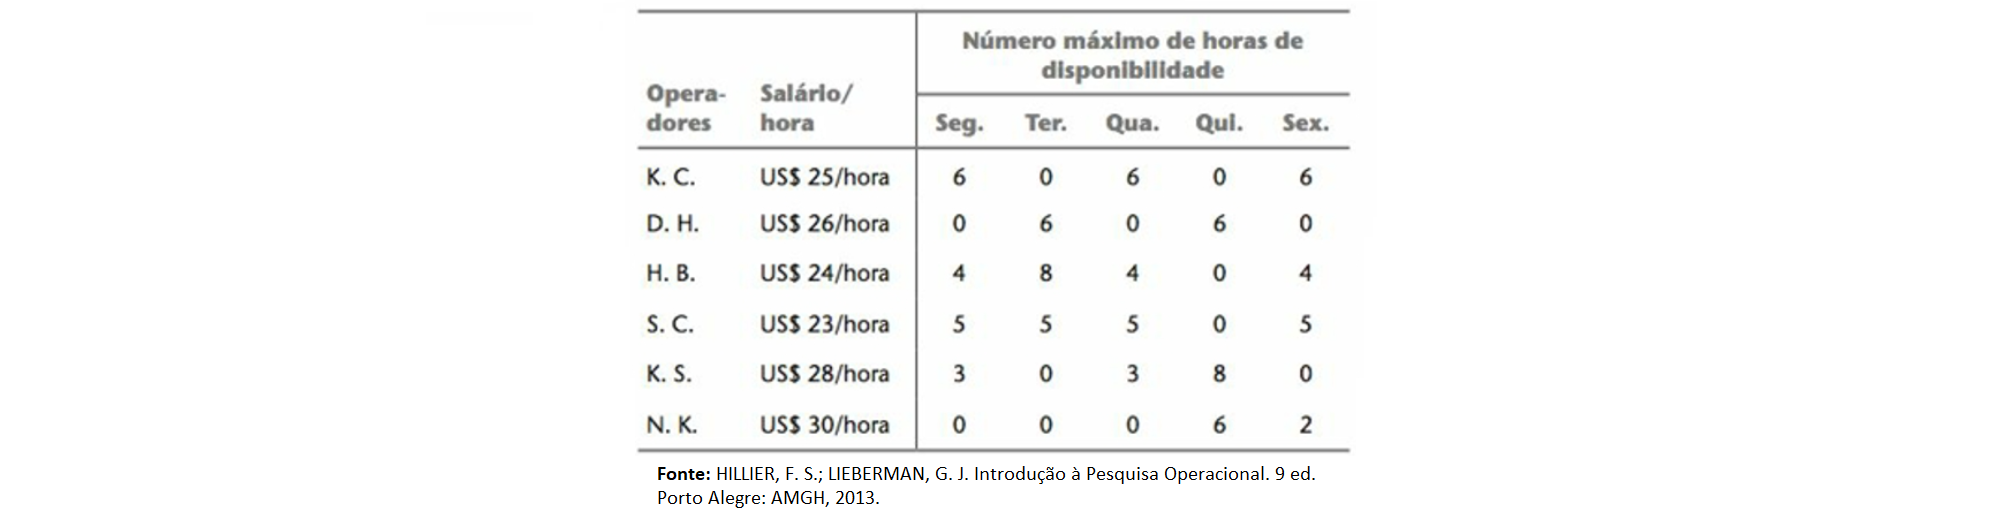

Há seis operadores (há dois estudantes graduados e quatro ainda no curso). Todos eles têm salários diferentes em razão da experiência diversa com computadores e em termos de habilidade de programação. A tabela anterior mostra os salários junto com o número máximo de horas que cada deles um trabalha por dia. <br><br> Cada operador tem a garantia de certo número de horas por semana, que fará com que eles mantenham o conhecimento adequado sobre a operação. O nível é estabelecido arbitrariamente em oito horas por semana para os estudantes não formados (K. C., D. H., H. B. e S.C.) e sete horas por semana para os estudantes graduados (K. S. e N. K.). <br><br> O centro de computação deve permanecer aberto para operação das 8h até as 22h, de segunda-feira à sexta-feira, com exatamente um operador de plantão durante esse período. Aos sábados e domingos o computador deve ser operado por outra equipe. <br><br> Devido ao orçamento apertado, Beryl tem de minimizar o custo. Ela quer determinar o número de horas que deve atribuir a cada operador em cada dia da semana.
___

<b>Resolução:</b> <br>
<font color='blue'> Função objetivo </font> (<b>Z</b>): <br>
<b>25(x₁+x₂+x₃+x₄+x₅)+26(x₆+x₇+x₈+x₉+x₁₀)+24(x₁₁+x₁₂+x₁₃+x₁₄+x₁₅)+
    23(x₁₆+x₁₇+x₁₈+x₁₉+x₂₀)+28(x₂₁+x₂₂+x₂₃+x₂₄+x₂₅)+30(x₂₆+x₂₇+x₂₈+x₂₉+x₃₀)</b> <br>
<font color='red'> Conjunto viável: </font><br>
Restrição de K.C.: <br>
(<b>KC₁</b>): <b>x₁≤6 </b> (agenda)<br>
(<b>KC₂</b>): <b>x₂=0 </b> (agenda)<br>
(<b>KC₃</b>): <b>x₃≤6 </b> (agenda)<br>
(<b>KC₄</b>): <b>x₄=0 </b> (agenda)<br>
(<b>KC₅</b>): <b>x₅≤6 </b> (agenda)<br>
(<b>KC₆</b>): <b>x₁+x₂+x₃+x₄+x₅≥8 </b> (nv mín)<br>
Restrição de D.H.: <br>
(<b>DH₁</b>): <b>x₆=0 </b> (agenda)<br>
(<b>DH₂</b>): <b>x₇≤6 </b> (agenda)<br>
(<b>DH₃</b>): <b>x₈=0 </b> (agenda)<br>
(<b>DH₄</b>): <b>x₉≤6 </b> (agenda)<br>
(<b>DH₅</b>): <b>x₁₀=0 </b> (agenda)<br>
(<b>DH₆</b>): <b>x₆+x₇+x₈+x₉+x₁₀≥8 </b> (nv mín)<br>
Restrição de H.B.: <br>
(<b>HB₁</b>): <b>x₁₁≤4 </b> (agenda)<br>
(<b>HB₂</b>): <b>x₁₂≤8 </b> (agenda)<br>
(<b>HB₃</b>): <b>x₁₃≤4 </b> (agenda)<br>
(<b>HB₄</b>): <b>x₁₄=0 </b> (agenda)<br>
(<b>HB₅</b>): <b>x₁₅≤4 </b> (agenda)<br>
(<b>HB₆</b>): <b>x₁₁+x₁₂+x₁₃+x₁₄+x₁₅≥8 </b> (nv mín)<br>
Restrição de S.C.: <br>
(<b>SC₁</b>): <b>x₁₆≤5 </b> (agenda)<br>
(<b>SC₂</b>): <b>x₁₇≤5 </b> (agenda)<br>
(<b>SC₃</b>): <b>x₁₈≤5 </b> (agenda)<br>
(<b>SC₄</b>): <b>x₁₉=0 </b> (agenda)<br>
(<b>SC₅</b>): <b>x₂₀≤5 </b> (agenda)<br>
(<b>SC₆</b>): <b>x₁₆+x₁₇+x₁₈+x₁₉+x₂₀≥8 </b> (nv mín)<br>
Restrição de K.S.: <br>
(<b>KS₁</b>): <b>x₂₁≤3 </b> (agenda)<br>
(<b>KS₂</b>): <b>x₂₂=0 </b> (agenda)<br>
(<b>KS₃</b>): <b>x₂₃≤3 </b> (agenda)<br>
(<b>KS₄</b>): <b>x₂₄≤8 </b> (agenda)<br>
(<b>KS₅</b>): <b>x₂₅=0 </b> (agenda)<br>
(<b>KS₆</b>): <b>x₂₁+x₂₂+x₂₃+x₂₄+x₂₅≥7 </b> (nv mín)<br>
Restrição de N.K.: <br>
(<b>NK₁</b>): <b>x₂₆=0 </b> (agenda)<br>
(<b>NK₂</b>): <b>x₂₇=0 </b> (agenda)<br>
(<b>NK₃</b>): <b>x₂₈=0 </b> (agenda)<br>
(<b>NK₄</b>): <b>x₂₉≤6 </b> (agenda)<br>
(<b>NK₅</b>): <b>x₃₀≤2 </b> (agenda)<br>
(<b>NK₆</b>): <b>x₂₆+x₂₇+x₂₈+x₂₉+x₃₀≥7 </b> (nv mín)<br>
Cota diária: <br>
(<b>D₁</b>): <b>x₁+x₆+x₁₁+x₁₆+x₂₁+x₂₆=14</b> (seg)<br>
(<b>D₂</b>): <b>x₂+x₇+x₁₂+x₁₇+x₂₂+x₂₇=14</b> (ter)<br>
(<b>D₃</b>): <b>x₃+x₈+x₁₃+x₁₈+x₂₃+x₂₈=14</b> (qua)<br>
(<b>D₄</b>): <b>x₄+x₉+x₁₄+x₁₉+x₂₄+x₂₉=14</b> (qui)<br>
(<b>D₅</b>): <b>x₅+x₁₀+x₁₅+x₂₀+x₂₅+x₃₀=14</b> (sex)<br>

* as variáveis foram selecionadas sequencialmente de acordo com a disponibilidade de cada operador em cada dia da semana
* a carga horária diária é de 14 horas, período compreendido entre 08:00 e 22:00
* problema de otimização linear visando a minimização dos custos com salário de operadores

In [19]:
# Criando lista com o nome dos operadores
oprs = ['KC', 'DH', 'HB', 'SC', 'KS', 'NK']

# Criando lista de listas contendo o número máximo de horas
# de disponibilidade por operador por dia de semana
hmax = [[6, 0, 6, 0, 6],
        [0, 6, 0, 6, 0],
        [4, 8, 4, 0, 4],
        [5, 5, 5, 0, 5],
        [3, 0, 3, 8, 0],
        [0, 0, 0, 6, 2]]

# Criando lista com o mínimo de horas de cada operador para
# manter o conhecimento adequado sobre a operação
hmin = [8, 8, 8, 8, 7, 7]

# Criando lista com os salários/hora dos operadores
slrs = [25, 26, 24, 23, 28, 30]

# Criando o modelo
model = LpProblem(name = 'PROBLEMA_3', sense = LpMinimize)

# Iniciando as variáveis de decisão
cat = 'Continuous'
X = [LpVariable(name='x{0}'.format(i+1),lowBound=0,cat=cat) for i in range(30)]

# Adicionando as restrições e a função objetivo ao modelo
def rst_agg(rst,lst,hrs): 
    return [(rst+str(i+1),j) for i, j in enumerate(lst+[hrs])]
d = 0
f_obj = []
for e, f, g, h in zip(oprs, hmax, hmin, slrs):    
    tpl = rst_agg(e, f, g)
    for i, j in zip(X[d:d+5], tpl[:-1]):    
        if j[1] == 0:
            model += (i == j[1], j[0])
        else:
            model += (i <= j[1], j[0])
    f_obj.append(h*lpSum(X[d:d+5]))
    model += (lpSum(X[d:d+5]) >= tpl[-1][1], tpl[-1][0])
    d += 5
for i in range(5):
    model += (lpSum([X[j] for j in range(i, 30, 5)]) == 14, 'D{0}'.format(i+1))
model += lpSum(f_obj)

In [20]:
# Verificando o modelo
print(str(model).replace('\n\n','\n'))

PROBLEMA_3:
MINIMIZE
25*x1 + 26*x10 + 24*x11 + 24*x12 + 24*x13 + 24*x14 + 24*x15 + 23*x16 + 23*x17 + 23*x18 + 23*x19 + 25*x2 + 23*x20 + 28*x21 + 28*x22 + 28*x23 + 28*x24 + 28*x25 + 30*x26 + 30*x27 + 30*x28 + 30*x29 + 25*x3 + 30*x30 + 25*x4 + 25*x5 + 26*x6 + 26*x7 + 26*x8 + 26*x9 + 0
SUBJECT TO
KC1: x1 <= 6
KC2: x2 = 0
KC3: x3 <= 6
KC4: x4 = 0
KC5: x5 <= 6
KC6: x1 + x2 + x3 + x4 + x5 >= 8
DH1: x6 = 0
DH2: x7 <= 6
DH3: x8 = 0
DH4: x9 <= 6
DH5: x10 = 0
DH6: x10 + x6 + x7 + x8 + x9 >= 8
HB1: x11 <= 4
HB2: x12 <= 8
HB3: x13 <= 4
HB4: x14 = 0
HB5: x15 <= 4
HB6: x11 + x12 + x13 + x14 + x15 >= 8
SC1: x16 <= 5
SC2: x17 <= 5
SC3: x18 <= 5
SC4: x19 = 0
SC5: x20 <= 5
SC6: x16 + x17 + x18 + x19 + x20 >= 8
KS1: x21 <= 3
KS2: x22 = 0
KS3: x23 <= 3
KS4: x24 <= 8
KS5: x25 = 0
KS6: x21 + x22 + x23 + x24 + x25 >= 7
NK1: x26 = 0
NK2: x27 = 0
NK3: x28 = 0
NK4: x29 <= 6
NK5: x30 <= 2
NK6: x26 + x27 + x28 + x29 + x30 >= 7
D1: x1 + x11 + x16 + x21 + x26 + x6 = 14
D2: x12 + x17 + x2 + x22 + x27 + x7 = 14
D3: x

<b>GLPK</b>

In [22]:
m_GLPK = solver_apply(model,solver='GLPK',kind='Min',method=0,keepFiles=False,imprimir=True); v_GLPK = m_GLPK.objective.value(); df_GLPK = calendar_apply(m_GLPK)

GLPK (Optimal):
Método: Automatico
Tempo: 0.0s
Z: 1755.0
x1: 2.0
x10: 0.0
x11: 4.0
x12: 7.0
x13: 4.0
x14: 0.0
x15: 4.0
x16: 5.0
x17: 5.0
x18: 5.0
x19: 0.0
x2: 0.0
x20: 5.0
x21: 3.0
x22: 0.0
x23: 2.0
x24: 2.0
x25: 0.0
x26: 0.0
x27: 0.0
x28: 0.0
x29: 6.0
x3: 3.0
x30: 1.0
x4: 0.0
x5: 4.0
x6: 0.0
x7: 2.0
x8: 0.0
x9: 6.0
KC1: -4.0
KC2: 0.0
KC3: -3.0
KC4: 0.0
KC5: -2.0
KC6: 1.0
DH1: 0.0
DH2: -4.0
DH3: 0.0
DH4: 0.0
DH5: 0.0
DH6: 0.0
HB1: 0.0
HB2: -1.0
HB3: 0.0
HB4: 0.0
HB5: 0.0
HB6: 11.0
SC1: 0.0
SC2: 0.0
SC3: 0.0
SC4: 0.0
SC5: 0.0
SC6: 12.0
KS1: 0.0
KS2: 0.0
KS3: -1.0
KS4: -6.0
KS5: 0.0
KS6: 0.0
NK1: 0.0
NK2: 0.0
NK3: 0.0
NK4: 0.0
NK5: -1.0
NK6: 0.0
D1: 0.0
D2: 0.0
D3: 0.0
D4: 0.0
D5: 0.0
------------------------------------------------------------
Min Z = 1755.0, x = (2.0, 0.0, 4.0, 7.0, 4.0, 0.0, 4.0, 5.0, 5.0, 5.0, 0.0, 0.0, 5.0, 3.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 6.0, 3.0, 1.0, 0.0, 4.0, 0.0, 2.0, 0.0, 6.0)


<b>CPLEX</b>

In [23]:
m_CPLEX = solver_apply(model,solver='CPLEX',kind='Min',method=0,keepFiles=False,imprimir=True); v_CPLEX = m_CPLEX.objective.value(); df_CPLEX = calendar_apply(m_CPLEX)

CPLEX (Optimal):
Método: Automatico
Tempo: 0.0s
Z: 1755.0
x1: 2.0
x10: 0.0
x11: 4.0
x12: 7.0
x13: 4.0
x14: 0.0
x15: 4.0
x16: 5.0
x17: 5.0
x18: 5.0
x19: 0.0
x2: 0.0
x20: 5.0
x21: 3.0
x22: 0.0
x23: 2.0
x24: 2.0
x25: 0.0
x26: 0.0
x27: 0.0
x28: 0.0
x29: 6.0
x3: 3.0
x30: 1.0
x4: 0.0
x5: 4.0
x6: 0.0
x7: 2.0
x8: 0.0
x9: 6.0
KC1: -4.0
KC2: 0.0
KC3: -3.0
KC4: 0.0
KC5: -2.0
KC6: 1.0
DH1: 0.0
DH2: -4.0
DH3: 0.0
DH4: 0.0
DH5: 0.0
DH6: 0.0
HB1: 0.0
HB2: -1.0
HB3: 0.0
HB4: 0.0
HB5: 0.0
HB6: 11.0
SC1: 0.0
SC2: 0.0
SC3: 0.0
SC4: 0.0
SC5: 0.0
SC6: 12.0
KS1: 0.0
KS2: 0.0
KS3: -1.0
KS4: -6.0
KS5: 0.0
KS6: 0.0
NK1: 0.0
NK2: 0.0
NK3: 0.0
NK4: 0.0
NK5: -1.0
NK6: 0.0
D1: 0.0
D2: 0.0
D3: 0.0
D4: 0.0
D5: 0.0
------------------------------------------------------------
Min Z = 1755.0, x = (2.0, 0.0, 4.0, 7.0, 4.0, 0.0, 4.0, 5.0, 5.0, 5.0, 0.0, 0.0, 5.0, 3.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 6.0, 3.0, 1.0, 0.0, 4.0, 0.0, 2.0, 0.0, 6.0)


<b>GUROBI</b>

In [24]:
m_GUROBI = solver_apply(model,solver='GUROBI',kind='Min',method=0,keepFiles=False,imprimir=True); v_GUROBI = m_GUROBI.objective.value(); df_GUROBI = calendar_apply(m_GUROBI)

GUROBI (Optimal):
Método: Automatico
Tempo: 0.0s
Z: 1755.0
x1: 4.0
x10: 0.0
x11: 4.0
x12: 7.0
x13: 4.0
x14: 0.0
x15: 4.0
x16: 5.0
x17: 5.0
x18: 5.0
x19: 0.0
x2: 0.0
x20: 5.0
x21: 1.0
x22: 0.0
x23: 3.0
x24: 3.0
x25: 0.0
x26: 0.0
x27: 0.0
x28: 0.0
x29: 5.0
x3: 2.0
x30: 2.0
x4: 0.0
x5: 3.0
x6: 0.0
x7: 2.0
x8: 0.0
x9: 6.0
KC1: -2.0
KC2: 0.0
KC3: -4.0
KC4: 0.0
KC5: -3.0
KC6: 1.0
DH1: 0.0
DH2: -4.0
DH3: 0.0
DH4: 0.0
DH5: 0.0
DH6: 0.0
HB1: 0.0
HB2: -1.0
HB3: 0.0
HB4: 0.0
HB5: 0.0
HB6: 11.0
SC1: 0.0
SC2: 0.0
SC3: 0.0
SC4: 0.0
SC5: 0.0
SC6: 12.0
KS1: -2.0
KS2: 0.0
KS3: 0.0
KS4: -5.0
KS5: 0.0
KS6: 0.0
NK1: 0.0
NK2: 0.0
NK3: 0.0
NK4: -1.0
NK5: 0.0
NK6: 0.0
D1: 0.0
D2: 0.0
D3: 0.0
D4: 0.0
D5: 0.0
------------------------------------------------------------
Min Z = 1755.0, x = (4.0, 0.0, 4.0, 7.0, 4.0, 0.0, 4.0, 5.0, 5.0, 5.0, 0.0, 0.0, 5.0, 1.0, 0.0, 3.0, 3.0, 0.0, 0.0, 0.0, 0.0, 5.0, 2.0, 2.0, 0.0, 3.0, 0.0, 2.0, 0.0, 6.0)


<b> Como resultado, a diretora Beryl Ingram deveria, visando minimizar seu custo semanal com salário de operadores - para o valor de US$ 1.755,00 -, adotar uma das seguintes escalas, existindo mais de uma solução ótima para o problema em questão: </b>

In [25]:
print()
print(f'\033[1mGLPK ({v_GLPK})\033[0m')
display(df_GLPK)
print('\n', f'\033[1mCPLEX ({v_CPLEX})\033[0m', sep = '')
display(df_CPLEX)
print('\n', f'\033[1mGUROBI ({v_GUROBI})\033[0m', sep = '')
display(df_GUROBI)


GLPK (1755.0)


,Seg.,Ter.,Qua.,Qui.,Sex.,TOTAL
K.C.,2.0,0.0,3.0,0.0,4.0,9.0
D.H.,0.0,2.0,0.0,6.0,0.0,8.0
H.B.,4.0,7.0,4.0,0.0,4.0,19.0
S.C.,5.0,5.0,5.0,0.0,5.0,20.0
K.S.,3.0,0.0,2.0,2.0,0.0,7.0
N.K.,0.0,0.0,0.0,6.0,1.0,7.0
TOTAL,14.0,14.0,14.0,14.0,14.0,70.0



CPLEX (1755.0)


,Seg.,Ter.,Qua.,Qui.,Sex.,TOTAL
K.C.,2.0,0.0,3.0,0.0,4.0,9.0
D.H.,0.0,2.0,0.0,6.0,0.0,8.0
H.B.,4.0,7.0,4.0,0.0,4.0,19.0
S.C.,5.0,5.0,5.0,0.0,5.0,20.0
K.S.,3.0,0.0,2.0,2.0,0.0,7.0
N.K.,0.0,0.0,0.0,6.0,1.0,7.0
TOTAL,14.0,14.0,14.0,14.0,14.0,70.0



GUROBI (1755.0)


,Seg.,Ter.,Qua.,Qui.,Sex.,TOTAL
K.C.,4.0,0.0,2.0,0.0,3.0,9.0
D.H.,0.0,2.0,0.0,6.0,0.0,8.0
H.B.,4.0,7.0,4.0,0.0,4.0,19.0
S.C.,5.0,5.0,5.0,0.0,5.0,20.0
K.S.,1.0,0.0,3.0,3.0,0.0,7.0
N.K.,0.0,0.0,0.0,5.0,2.0,7.0
TOTAL,14.0,14.0,14.0,14.0,14.0,70.0


___
___

### Métodos

Em todos os problemas, os três solvers apresentados empregaram o mesmo método - <b>Dual Simplex</b> - para encontrar a solução ótima, como resultado de um algoritmo de seleção inicialmente executado. A título ilustrativo, registra-se abaixo o log da resolução do <b>Problema 3</b> pelo solver CPLEX:

In [26]:
status = solver_apply(model, solver = 'CPLEX', kind = 'Min', method = 6, keepFiles = True, imprimir = False)
with open('cplex.log') as f: lines = f.readlines()
for lg in ['cplex.log','PROBLEMA_3-pulp.lp', 'PROBLEMA_3-pulp.sol']: os.remove(lg)
for i in lines:
    if i[:12] == 'Dual simplex' or '*' in i:
        print('\033[1m' + i + '\033[0m')
    elif i == '\n':
        pass
    else:
        print(i)

Log started (V20.1.0.0) Mon May 17 12:43:05 2021

Problem 'PROBLEMA_3-pulp.lp' read.

Read time = 0.00 sec. (0.00 ticks)

New value for method for linear optimization: 6

Version identifier: 20.1.0.0 | 2020-11-11 | 9bedb6d68

CPXPARAM_LPMethod                                6

Parallel mode: deterministic, using up to 12 threads for concurrent optimization:

 * Starting dual Simplex on 1 thread...

 * Starting Barrier on 10 threads...

 * Starting primal Simplex on 1 thread...

Tried aggregator 1 time.

LP Presolve eliminated 30 rows and 12 columns.

Reduced LP has 11 rows, 18 columns, and 36 nonzeros.

Presolve time = 0.00 sec. (0.02 ticks)

Initializing dual steep norms . . .

Iteration log . . .

Iteration:     1   Dual objective     =          1735.000000

Dual simplex solved model.

Dual simplex - Optimal:  Objective =  1.7550000000e+03

Solution time =    0.00 sec.  Iterations = 5 (0)

Deterministic time = 0.05 ticks  (48.06 ticks/sec)

Solution written to file 'PROBLEMA_3-pulp.s

___
De modo a ilustrar outras metodologias, apresentam-se a seguir exemplos de resoluções alternativas para os Problemas 1 e 2.

<b>Problema 1 - resolução pelo método de otimização Barrier do solver Gurobi.</b>

In [27]:
# Criando o modelo
model = LpProblem(name = 'PROBLEMA_1', sense = LpMaximize)

# Iniciando as variáveis de decisão
x1 = LpVariable(name = 'x1', lowBound=0, cat = 'Integer')
x2 = LpVariable(name = 'x2', lowBound=0, cat = 'Integer')
x3 = LpVariable(name = 'x3', lowBound=0, cat = 'Integer')

# Adicionando as restrições ao modelo
model += (9*x1 + 3*x2 + 5*x3 <= 500, 'r1')
model += (5*x1 + 4*x2 + 0*x3 <= 350, 'r2')
model += (3*x1 + 0*x2 + 2*x3 <= 150, 'r3')
model += (x3 <= 20, 'r4')

# Adicionando a função objetivo ao modelo
model += 50*x1 + 20*x2 + 25*x3

#Solucionando o problema
status = solver_apply(model, solver = 'GUROBI', kind = 'Max', method = 3, keepFiles = True, imprimir = True)
print('\n')
with open('gurobi.log') as f: lines = f.readlines()
for lg in ['gurobi.log','PROBLEMA_1-pulp.lp', 'PROBLEMA_1-pulp.sol']: os.remove(lg)
for i in lines:
    if i[:20] == 'Set parameter Method' or i[:14] == 'Barrier solved':
        print('\033[1m' + i + '\033[0m')
    elif i == '\n':
        pass
    else:
        print(i)

GUROBI (Optimal):
Método: Barrier
Tempo: 0.015625s
Z: 2900.0
x1: 26.0
x2: 55.0
x3: 20.0
r1: -1.0
r2: 0.0
r3: -32.0
r4: 0.0
------------------------------------------------------------
Max Z = 2900.0, x = (26.0, 55.0, 20.0)


Gurobi 9.1.2 (win64, gurobi_cl) logging started Mon May 17 12:43:11 2021

Academic license - for non-commercial use only - expires 2021-07-05

Using license file C:\Users\later\gurobi.lic

Set parameter Method to value 2

Set parameter LogFile to value gurobi.log

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)

Copyright (c) 2021, Gurobi Optimization, LLC

Read LP format model from file PROBLEMA_1-pulp.lp

Reading time = 0.00 seconds

OBJ: 4 rows, 3 columns, 8 nonzeros

Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 4 rows, 3 columns and 8 nonzeros

Model fingerprint: 0x9d5e6c10

Variable types: 0 continuous, 3 integer (0 binary)

Coefficient statistics:

  Matrix range     [1e+00, 9e+00]

  Objective ra

<b>Problema 2 - resolução pelo método de otimização Primal Simplex do solver CPLEX.</b>

In [28]:
# Criando o modelo
model = LpProblem(name = 'PROBLEMA_2', sense = LpMinimize)

# Iniciando as variáveis de decisão
x1 = LpVariable(name = 'x1', lowBound=0, cat = 'Integer')
x2 = LpVariable(name = 'x2', lowBound=0, cat = 'Integer')
x3 = LpVariable(name = 'x3', lowBound=0, cat = 'Integer')
x4 = LpVariable(name = 'x4', lowBound=0, cat = 'Integer')
x5 = LpVariable(name = 'x5', lowBound=0, cat = 'Integer')
x6 = LpVariable(name = 'x6', lowBound=0, cat = 'Integer')

# Adicionando as restrições ao modelo
model += (x1 + x2 + x3 == 400, 'r1')
model += (x4 + x5 + x6 == 500, 'r2')
model += (x1 + x4 == 300, 'r3')
model += (x2 + x5 == 200, 'r4')
model += (x3 + x6 == 400, 'r5')

# Adicionando a função objetivo ao modelo
model += 600*x1 + 800*x2 + 700*x3 + 400*x4 + 900*x5 + 600*x6

#Solucionando o problema
status = solver_apply(model, solver = 'CPLEX', kind = 'Min', method = 1, keepFiles = True, imprimir = True)
print('\n')
with open('cplex.log') as f: lines = f.readlines()
for lg in ['cplex.log','PROBLEMA_2-pulp.lp', 'PROBLEMA_2-pulp.sol']: os.remove(lg)
for i in lines:
    if i[:17] == 'CPXPARAM_LPMethod' or i[:14] == 'Primal simplex':
        print('\033[1m' + i + '\033[0m')
    elif i == '\n':
        pass
    else:
        print(i)

CPLEX (Optimal):
Método: Primal Simplex
Tempo: 0.0s
Z: 540000.0
x1: 0.0
x2: 200.0
x3: 200.0
x4: 300.0
x5: 0.0
x6: 200.0
r1: 0.0
r2: 0.0
r3: 0.0
r4: 0.0
r5: 0.0
------------------------------------------------------------
Min Z = 540000.0, x = (0.0, 200.0, 200.0, 300.0, 0.0, 200.0)


Log started (V20.1.0.0) Mon May 17 12:43:22 2021

Problem 'PROBLEMA_2-pulp.lp' read.

Read time = 0.00 sec. (0.00 ticks)

New value for method for linear optimization: 1

Version identifier: 20.1.0.0 | 2020-11-11 | 9bedb6d68

CPXPARAM_LPMethod                                1

Found incumbent of value 590000.000000 after 0.00 sec. (0.00 ticks)

Tried aggregator 2 times.

MIP Presolve eliminated 2 rows and 3 columns.

Aggregator did 3 substitutions.

All rows and columns eliminated.

Presolve time = 0.00 sec. (0.01 ticks)

Root node processing (before b&c):

  Real time             =    0.00 sec. (0.01 ticks)

Parallel b&c, 12 threads:

  Real time             =    0.00 sec. (0.00 ticks)

  Sync time (averag